# Preprocessing of the raw final map

## 1. Loading libraries, parameters and data

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import json

from joblib import Parallel, delayed

from scipy.signal import savgol_filter

In [2]:
from ddae1d.utils import despike_iterative, baseline_correction
from ddae1d.paths import PROJECT_ROOT

### Loading parameters

Modify them in `./config.json` if needed.

In [3]:
with open("config.json", "r") as f:
    config = json.load(f)

In [4]:
raw_finalmap_filename = config["raw_finalmap_filename"]

trim_spectra = config["trim_spectra"]
spectral_ends = config["spectral_ends"]

apply_savgol = config["apply_savgol"]
savgol_params = config["savgol_params"]

apply_despike = config["apply_despike"]
n_jobs_despike = config["n_jobs_despike"]
despike_params = config["despike_params"]

apply_baseline_correction = config["apply_baseline_correction"]
polyfit_degree = config["polyfit_degree"]

### Loading raw training data

In [5]:
raw_finalmap = np.load(PROJECT_ROOT / "data" / "raw" / "final-map" / raw_finalmap_filename)

## 2. Trimming spectral ends and substracting offset

### *If needed, trim the spectral ends to remove artefacts such as Rayleigh scattering*

Spectra must be trimmed in the same way as the training data.

Modify the values of `trim_spectra` and `spectral_ends` in `./config.json` if needed.

In [6]:
if trim_spectra:
    # Trim spectral ends
    finalmap = raw_finalmap[:, spectral_ends[0]:spectral_ends[1]]
else:
    finalmap = raw_finalmap

In [7]:
del raw_finalmap

### *If relevant, subtract an 'offset' baseline - common to the whole dataset. This should be done from the raw spectra before further preprocessing.*

#### Suggested method for computing the offset: Savitzky-Golay smoothed spectrum with lowest mean intensity

*Tune Savitzky-Golay filter parameters in `config.json`*

Index of spectrum with lowest mean intensity: 30061
Savitzky-Golay filter parameters: {'window_length': 111, 'polyorder': 3}


/tmp/ipykernel_54416/3747202985.py:4: RuntimeWarning: Mean of empty slice
  lowest_mean_idx = np.nanargmin(np.nanmean(finalmap, axis=1))


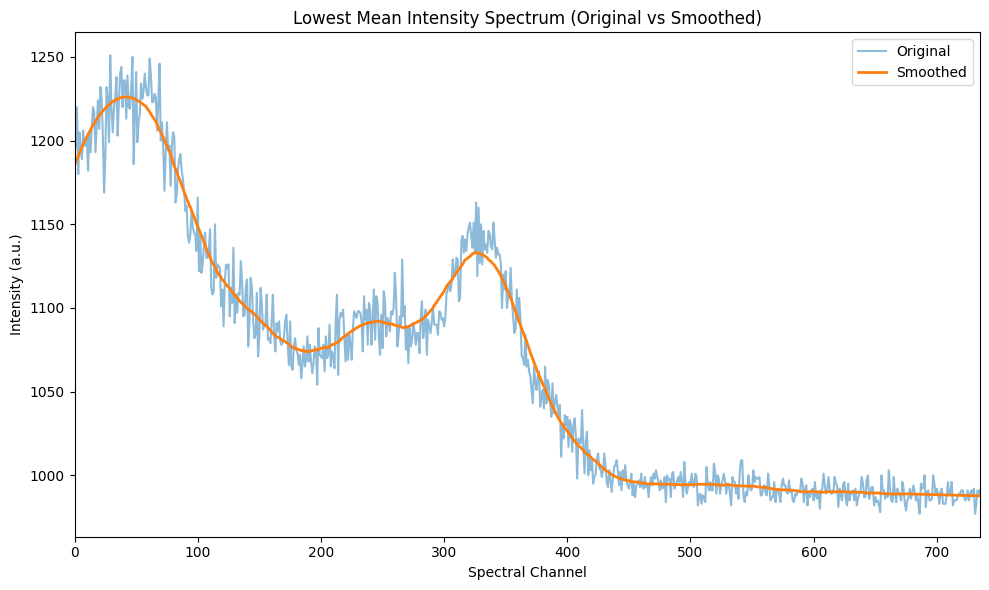

In [8]:
# If Savitzky-Golay smoothing is enabled, subtract a smoothed baseline from all spectra
if apply_savgol:
    # Find the index of the spectrum with the lowest mean intensity
    lowest_mean_idx = np.nanargmin(np.nanmean(finalmap, axis=1))
    print(f"Index of spectrum with lowest mean intensity: {lowest_mean_idx}")

    # Extract the spectrum with the lowest mean intensity
    lowest_mean_spectrum = finalmap[lowest_mean_idx]

    # Show the Savitzky-Golay filter parameters
    print(f"Savitzky-Golay filter parameters: {savgol_params}")

    # Smooth the lowest mean intensity spectrum using Savitzky-Golay filter
    smoothed_spectrum = savgol_filter(lowest_mean_spectrum, **savgol_params)

    # Plot the original and smoothed spectrum for visual inspection
    plt.figure(figsize=(10, 6))
    plt.plot(lowest_mean_spectrum, label="Original", alpha=0.5)
    plt.plot(smoothed_spectrum, label="Smoothed", linewidth=2)
    plt.xlabel("Spectral Channel")
    plt.ylabel("Intensity (a.u.)")
    plt.title("Lowest Mean Intensity Spectrum (Original vs Smoothed)")
    plt.xlim(0, len(lowest_mean_spectrum) - 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Subtract the smoothed baseline from all spectra in the training set
    finalmap_after_offset = finalmap - smoothed_spectrum
else:
    finalmap_after_offset = finalmap

In [9]:
del finalmap

## 3. Despiking (parallel processing)

Tune the number of parallel jobs: `n_jobs_despike` in `config.json`

In [10]:
def despike_task(point):
    despiked_spectrum, spikes_spectrum = despike_iterative(
        finalmap_after_offset[point, :],
        **despike_params
    )
    return (point, despiked_spectrum, spikes_spectrum)

In [12]:
if apply_despike:
    print(f"Number of jobs for parallel despiking: {n_jobs_despike % (os.cpu_count() + 1)}")
    spikes = np.zeros_like(finalmap_after_offset)
    finalmap_after_despike = np.zeros_like(finalmap_after_offset)
    print("Starting parallel despiking of final map...")
    print(f"Total spectra to despike (tasks to do): {finalmap_after_offset.shape[0]}")
    results = Parallel(n_jobs=n_jobs_despike, verbose=1)(
        delayed(despike_task)(point)
        for point in range(finalmap_after_offset.shape[0])
    )
    for point, despiked_spectrum, spikes_spectrum in results:
        finalmap_after_despike[point, :] = despiked_spectrum
        spikes[point, :] = spikes_spectrum
    del results
    nonzero_indices = np.argwhere(np.any(spikes != 0, axis=-1)).squeeze()
    percentage_nonzero = len(nonzero_indices) / (finalmap_after_despike.shape[0]) * 100
    print(f"Percentage of spectra despiked: {percentage_nonzero:.2f}%")
    print("Number of spectra despiked:", len(nonzero_indices))
else:
    finalmap_after_despike = finalmap_after_offset

Number of jobs for parallel despiking: 18
Starting parallel despiking of final map...
Total spectra to despike (tasks to do): 64000


[Parallel(n_jobs=-5)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=-5)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-5)]: Done 476 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-5)]: Done 7488 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-5)]: Done 18688 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-5)]: Done 33088 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-5)]: Done 50688 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-5)]: Done 64000 out of 64000 | elapsed:  1.1min finished


Percentage of spectra despiked: 0.24%
Number of spectra despiked: 152


In [13]:
del finalmap_after_offset

### Plot 20 random examples of despiked spectra vs removed spikes
Verify that despiking is effective and does not remove relevant signal

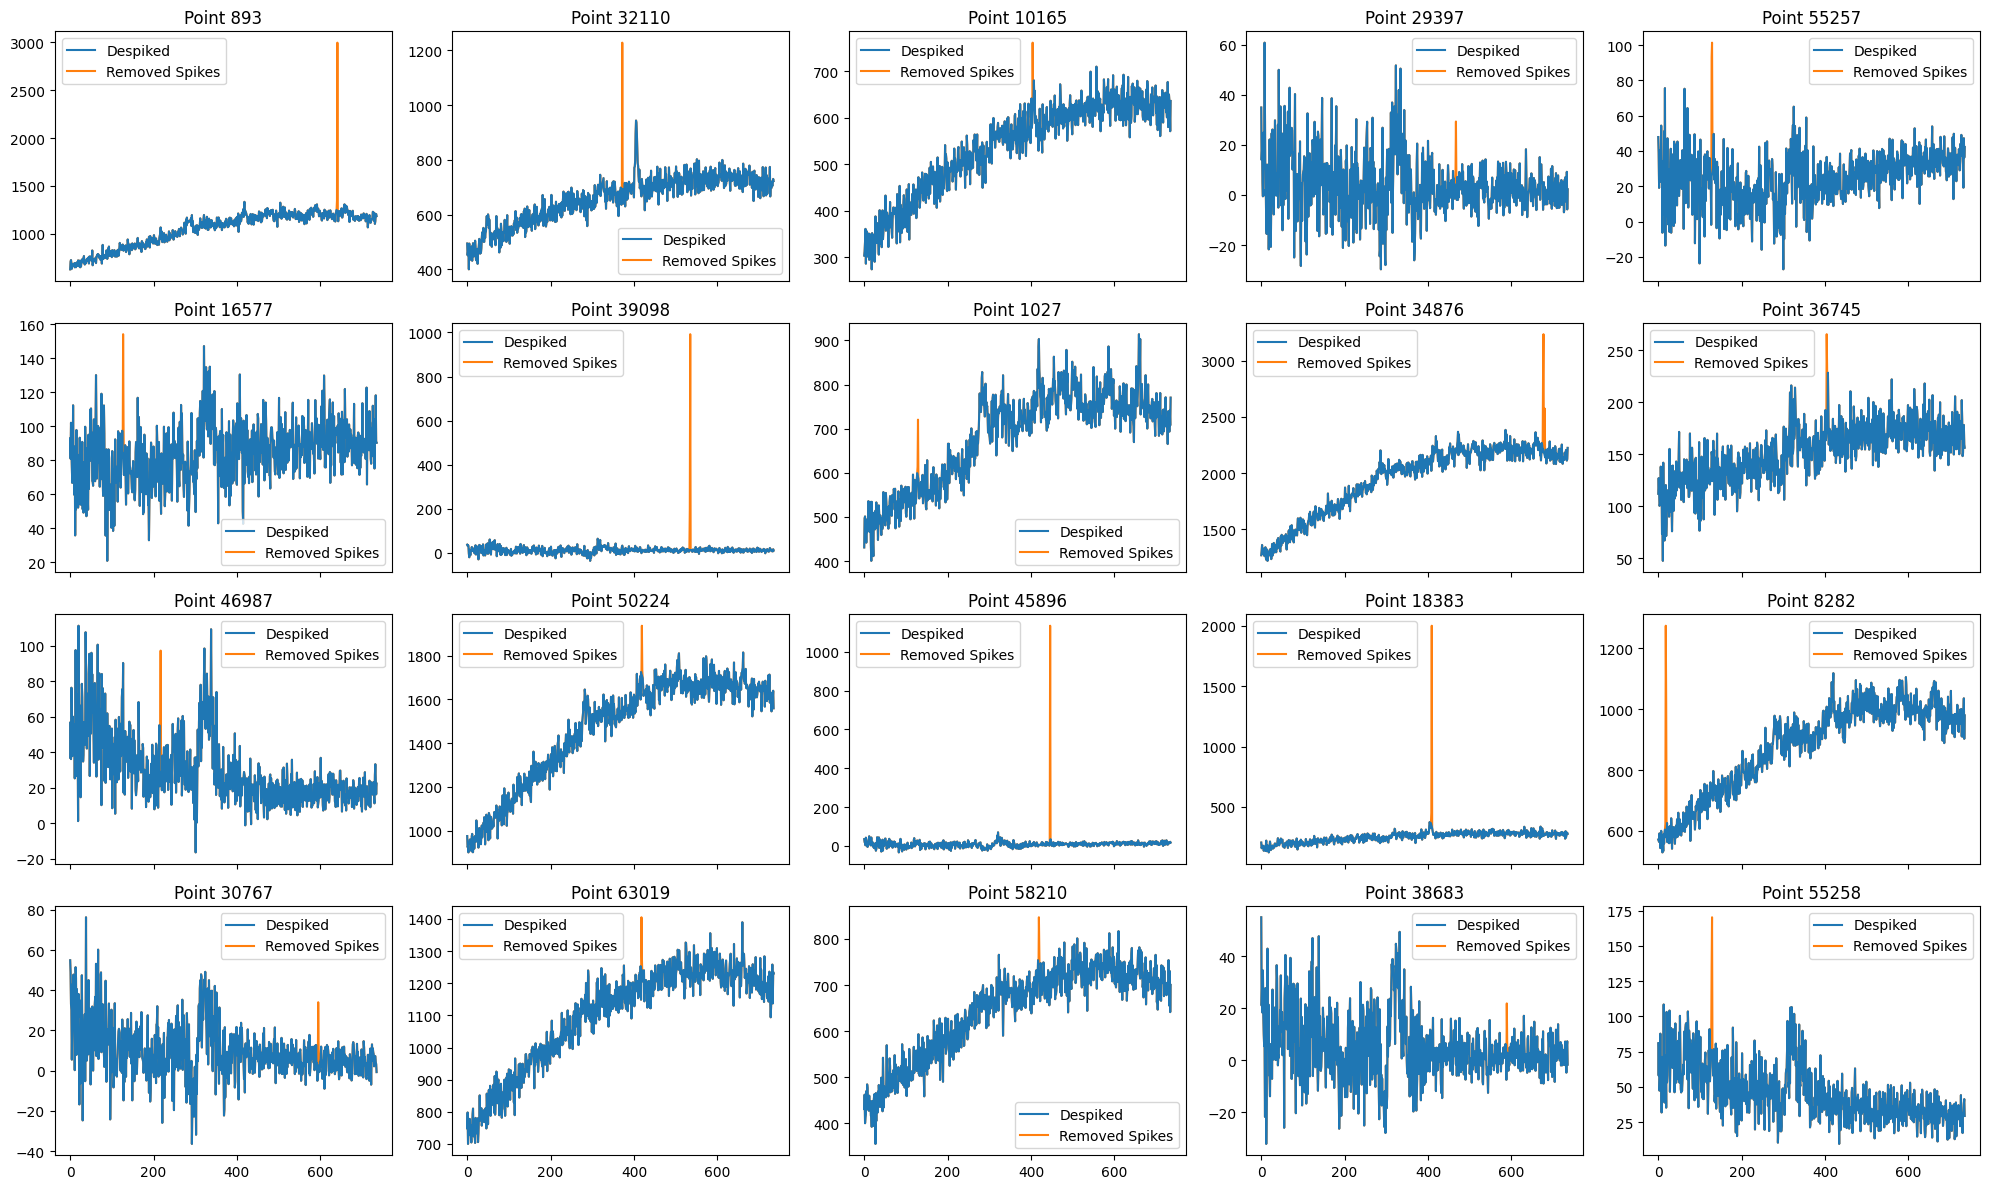

In [15]:
if apply_despike:
    n_plot = min(20, len(nonzero_indices))
    selected_indices = nonzero_indices[np.random.choice(len(nonzero_indices), n_plot, replace=False)]

    fig, axes = plt.subplots(4, 5, figsize=(20, 12), sharex=True, sharey=False)
    axes = axes.flatten()

    for ax, point in zip(axes, selected_indices):
        ax.plot(finalmap_after_despike[point], label='Despiked', zorder=1)
        ax.plot((finalmap_after_despike + spikes)[point], label='Removed Spikes', zorder=0)
        ax.set_title(f'Point {point}')
        ax.legend()

    plt.tight_layout()
    plt.show()

## 4. Baseline correction

In [16]:
if apply_baseline_correction:
    finalmap_after_baseline = baseline_correction(finalmap_after_despike, polyfit_degree)
else:
    finalmap_after_baseline = finalmap_after_despike

In [17]:
del finalmap_after_despike

## 5. Saving preprocessed training data

In [19]:
np.save(PROJECT_ROOT / "data" / "preprocessed" / "final-map" / "preprocessed-final-map.npy", finalmap_after_baseline)